# Welcome to CS 5242 **Homework 7**

ASSIGNMENT DEADLINE ⏰ : **6 Nov 2022, 23:59**

In this assignment, we have three questions. This is the second question and please write the answer in this notebook.

Colab is a hosted Jupyter notebook service that requires no setup to use, while providing access free of charge to computing resources including GPUs. In this semester, we will use Colab to run our experiments.

### **Grades Policy**

We have 10 points for this homework. 15% off per day late, 0 scores if you submit it 7 days after the deadline.

### **Cautions**

**DO NOT** copy the code from the internet, e.g. GitHub.

**DO NOT** use external libraries like Tensorflow, keras in your implementation.

---

### **Contact**

Please feel free to contact us if you have any question about this homework or need any further information.

Slack (Recommend): Lin Qiuxia

TA Email: qiuxia.lin@u.nus.edu

> If you have not join the slack group, you can click [here](https://join.slack.com/t/cs5242ay20222-oiw1784/shared_invite/zt-1eiv24k1t-0J9EI7vz3uQmAHa68qU0aw)

# Question 2 (3 Points)
In this Question, we'll leverage the U-Net architecture to predict the class that corresponds to all the pixels in the image. 

Most codes are provided and a few codes are missing. Please enter your codes in the highlighted parts and run all the cells to provide proper outputs. 

Feel free to adjust model hyperparameter values when training the model. 

In [1]:
import os
if not os.path.exists('dataset1'):
    !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip
    !rm dataset1.zip
    !pip install -q torch_snippets pytorch_model_summary

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 54 kB 818 kB/s 
     |████████████████████████████████| 78 kB 2.3 MB/s 
     |████████████████████████████████| 58 kB 5.2 MB/s 
     |████████████████████████████████| 237 kB 49.7 MB/s 
     |████████████████████████████████| 1.6 MB 59.8 MB/s 
     |████████████████████████████████| 175 kB 64.8 MB/s 
     |████████████████████████████████| 2.2 MB 45.4 MB/s 
     |████████████████████████████████| 51 kB 5.9 MB/s 


In [2]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [3]:
class SegData(Dataset):
    def __init__(self, split):
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split
    def __len__(self):
        return len(self.items)
    def __getitem__(self, ix):
        image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224,224))
        mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')
        mask = cv2.resize(mask, (224,224))
        return image, mask
    def choose(self): return self[randint(len(self))]
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In [4]:
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

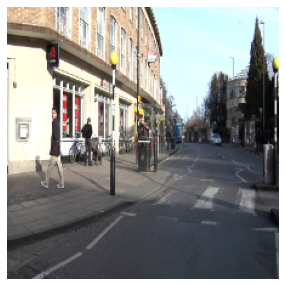

In [5]:
show(trn_ds[10][0])

In [6]:
trn_ds[10][0].shape

(224, 224, 3)

In [64]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [65]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU()
    )

In [66]:
from torchvision.models import vgg16_bn

class UNet(nn.Module):

    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()

        ###################################
        ###Please enter your codes here####
        ###################################
        self.layers = vgg16_bn(pretrained=pretrained).features

        self.layer1 = nn.Sequential(*self.layers[:6])
        self.layer2 = nn.Sequential(*self.layers[6:13])
        self.layer3 = nn.Sequential(*self.layers[13:20])
        self.layer4 = nn.Sequential(*self.layers[20:27])
        self.layer5 = nn.Sequential(*self.layers[27:34])
        self.bottleneck = nn.Sequential(*self.layers[34:])

        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)

        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)

        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)

        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)

        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)




        ####################################
    def forward(self, x):
        ###################################
        ###Please enter your codes here####
        ###################################
        
        down_1 = self.layer1(x)
        down_2 = self.layer2(down_1)
        down_3 = self.layer3(down_2)
        down_4 = self.layer4(down_3)
        down_5 = self.layer5(down_4)

        bottom = self.bottleneck(down_5)
        bottom = self.conv_bottleneck(bottom)

        up_5 = self.up_conv6(bottom)
        up_5 = torch.cat([up_5, down_5], dim=1)
        up_5 = self.conv6(up_5)

        up_4 = self.up_conv7(up_5)
        up_4 = torch.cat([up_4, down_4], dim=1)
        up_4 = self.conv7(up_4)

        up_3 = self.up_conv8(up_4)
        up_3 = torch.cat([up_3, down_3], dim=1)
        up_3 = self.conv8(up_3)

        up_2 = self.up_conv9(up_3)
        up_2 = torch.cat([up_2, down_2], dim=1)
        up_2 = self.conv9(up_2)

        up_1 = self.up_conv10(up_2)
        up_1 = torch.cat([up_1, down_1], dim=1)
        up_1 = self.conv10(up_1)

        x = self.conv11(up_1)

        ####################################

        return x

In [67]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [68]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [78]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

In [79]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
print("train_acc:", np.mean([v for pos, v in log.trn_acc]), "|val_acc:", np.mean([v for pos, v in log.val_acc]))

EPOCH: 20.000  val_loss: 0.272  val_acc: 0.921  (392.56s - 0.00s remaining)

train_acc: 0.8946254261040493 |val_acc: 0.875798024665011

100%|██████████| 121/121 [00:00<00:00, 949.44it/s]


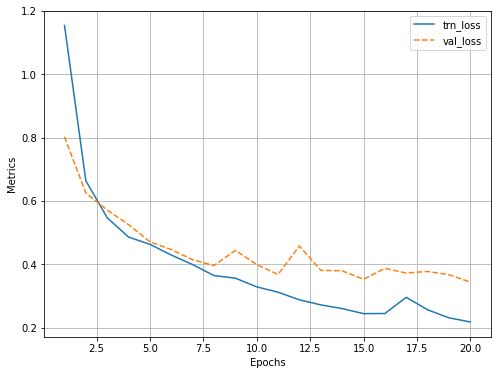

In [80]:
log.plot_epochs(['trn_loss','val_loss'])

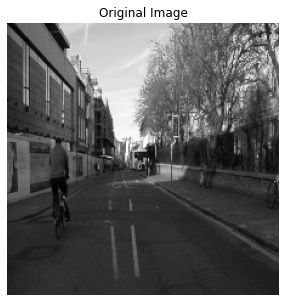

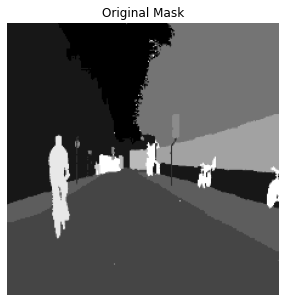

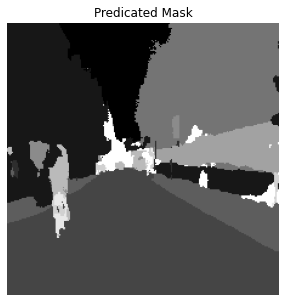

In [81]:
ims, masks = next(iter(val_dl))
output = model(ims)
_, _masks = torch.max(output, 1)
show(ims[0].permute(1,2,0).detach().cpu()[:,:,0], title ="Original Image")
show(masks.permute(1,2,0).detach().cpu()[:,:,0], title ="Original Mask")
show(_masks.permute(1,2,0).detach().cpu()[:,:,0], title ="Predicated Mask")